In [1]:
import librosa
import scipy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import csv
import soundfile as sf
import scipy.io.wavfile as wav
from scipy.fftpack import dct


import warnings
warnings.filterwarnings('ignore')

d:\Anaconda\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## Train

In [2]:
cur_dir = os.getcwd()
hc_directory = os.path.join(cur_dir, "../Data/Augment_Audio/Train/HC")
pd_directory = os.path.join(cur_dir, "../Data/Augment_Audio/Train/PD")
print(hc_directory)

d:\Python\Pipeline\PythonScripts\../Data/Augment_Audio/Train/HC


In [3]:
# hc_files = [os.path.join(hc_directory, filename) for filename in os.listdir(hc_directory) if filename.endswith(".wav")]
# pd_files = [os.path.join(pd_directory, filename) for filename in os.listdir(pd_directory) if filename.endswith(".wav")]
hc_files = [filename for filename in os.listdir(hc_directory) if filename.endswith(".wav")]
pd_files = [filename for filename in os.listdir(pd_directory) if filename.endswith(".wav")]


In [4]:
hc_aug = hc_directory
pd_aug = pd_directory

In [5]:
import numpy as np
import scipy.signal
import scipy.fftpack
import python_speech_features as psf

In [15]:
num_filters = 26

In [18]:
# Функция для извлечения MFCC признаков
def extract_features_nolib(directory, file):
    global num_filters
    name = f'{directory}/{file}'
    sample_rate, signal = wav.read(name)
    # Предположим, что длина сигнала равна 3 секундам и частота дискретизации 16000 Гц
   # Calculate the mfcc features based on the file data
    mfcc_feat = psf.mfcc(signal, sample_rate, nfft=1200, numcep=num_filters)

    num_filters = mfcc_feat.shape[1]
    # Извлечение Delta MFCC
    delta_feat = psf.delta(mfcc_feat, 2)

    # Извлечение Delta-Delta MFCC
    delta_delta_feat = psf.delta(delta_feat, 2)

    logfbank_feat = psf.logfbank(signal, sample_rate, nfft=1200)

    # Извлечение энергии
    energy = np.sum(mfcc_feat**2) / len(mfcc_feat)

    # Извлечение Zero Crossing Rate
    zcr = ((signal[:-1] * signal[1:]) < 0).sum() / len(signal)
    #zcr = ((signal[:-1] * signal[1:]) < 0).sum() / len(signal)

    # Calculate the filterbank from the audio file

    mfcc_feat_mean = np.mean(mfcc_feat, axis=0)
    delta_feat_mean = np.mean(delta_feat, axis=0)
    delta_delta_feat_mean = np.mean(delta_delta_feat, axis=0)
    logfbank_feat_mean = np.mean(logfbank_feat, axis=0)

    mfcc_feat_std = np.std(mfcc_feat, axis=0)
    delta_feat_std = np.std(delta_feat, axis=0)
    delta_delta_feat_std = np.std(delta_delta_feat, axis=0)
    logfbank_feat_std = np.std(logfbank_feat, axis=0)

    # print(mfcc_feat_mean.shape)
    # print(delta_feat_mean.shape)
    # print(delta_delta_feat_mean.shape)
    # print(logfbank_feat_mean.shape)

    label = -1
    if (directory.split('/')[-1] == "PD"):
        label = 1
    else:
        label = 0
    
    
    features = np.hstack([
        file,
        mfcc_feat_mean, 
        delta_feat_mean, 
        delta_delta_feat_mean, 
        logfbank_feat_mean,
        mfcc_feat_std,
        delta_feat_std,
        delta_delta_feat_std,
        logfbank_feat_std,
        energy, 
        zcr,
        label
    ])
    
    # features = [] 
    # features.append(file) # filename
    # features.extend([np.mean(e) for e in mfcc_feat.T])  # mfcc_mean<0..20>
    # features.extend([np.std(e) for e in mfcc_feat.T])   # mfcc_std

    return features



In [19]:
buffer = []
buffer_size = 20
buffer_counter = 0

# Создание заголовка для файла CSV.
header = ['filename']
header.extend([f'mfcc_mean{i}' for i in range(1, num_filters + 1)])
header.extend([f'delta_mfcc{i}' for i in range(1, num_filters + 1)])
header.extend([f'delta2_mfcc{i}' for i in range(1, num_filters + 1)])
header.extend([f'logfbank{i}' for i in range(1, 27)])

header.extend([f'mfcc_std{i}' for i in range(1, num_filters + 1)])
header.extend([f'delta_std{i}' for i in range(1, num_filters + 1)])
header.extend([f'delta2_std{i}' for i in range(1, num_filters + 1)])
header.extend([f'logfbank_std{i}' for i in range(1, 27)])
# header.extend(['cent_mean', 'cent_std', 'cent_skew', 'rolloff_mean', 'rolloff_std',
#                'label'])
header.extend(['energy', 'zcr', 'label'])

with open('train_dataset.csv', 'w', newline='') as file:
    writer = csv.writer(file, delimiter=',')
    writer.writerow(header)
    for directory, files in [(hc_directory, hc_files), (pd_directory, pd_files)]:
        for file in files:
            #features = extract_features(directory, file)
            features = extract_features_nolib(directory, file)


            if buffer_counter + 1 == buffer_size:
                buffer.append(features)
                writer.writerows(buffer)
                print(f"- [{directory.split('/')[-1]}] Write {len(buffer)} rows")
                buffer = []
                buffer_counter = 0
            else:
                buffer.append(features)
                buffer_counter += 1
        if buffer:
            writer.writerows(buffer)
            print(f"- [{directory.split('/')[-1]}] Write {len(buffer)} rows") 
        print(f"- [{directory.split('/')[-1]}] Writing complete")
        buffer = []
        buffer_counter = 0

In [ ]:
cur_dir = os.getcwd()
hc_test_directory = os.path.join(cur_dir, "../Data/Augment_Audio/Test/HC")
pd_test_directory = os.path.join(cur_dir, "../Data/Augment_Audio/Test/PD")

hc_test_files = [filename for filename in os.listdir(hc_test_directory) if filename.endswith(".wav")]
pd_test_files = [filename for filename in os.listdir(pd_test_directory) if filename.endswith(".wav")]

In [ ]:
buffer = []
buffer_size = 20
buffer_counter = 0

# Создание заголовка для файла CSV.
# header = ['filename']
# header.extend([f'mfcc_mean{i}' for i in range(1, 21)])
# header.extend([f'mfcc_std{i}' for i in range(1, 21)])
# # header.extend(['cent_mean', 'cent_std', 'cent_skew', 'rolloff_mean', 'rolloff_std',
# #                'label'])
# header.extend(['label'])
# header.extend([f'mfcc_mean{i}' for i in range(1, num_filters + 1)])
# header.extend([f'delta_mfcc{i}' for i in range(1, num_filters + 1)])
# header.extend([f'delta2_mfcc{i}' for i in range(1, num_filters + 1)])
# header.extend([f'logfbank{i}' for i in range(1, 27)])

# header.extend([f'mfcc_std{i}' for i in range(1, num_filters + 1)])
# header.extend([f'delta_std{i}' for i in range(1, num_filters + 1)])
# header.extend([f'delta2_std{i}' for i in range(1, num_filters + 1)])
# header.extend([f'logfbank_std{i}' for i in range(1, 27)])

# header.extend(['energy', 'zcr', 'label'])

with open('test_dataset.csv', 'w', newline='') as file:
    writer = csv.writer(file, delimiter=',')
    writer.writerow(header)
    for directory, files in [(hc_test_directory, hc_test_files), (pd_test_directory, pd_test_files)]:
        for file in files:
            #features = extract_features(directory, file)
            features = extract_features_nolib(directory, file)


            if buffer_counter + 1 == buffer_size:
                buffer.append(features)
                writer.writerows(buffer)
                print(f"- [{directory.split('/')[-1]}] Write {len(buffer)} rows")
                buffer = []
                buffer_counter = 0
            else:
                buffer.append(features)
                buffer_counter += 1
        if buffer:
            writer.writerows(buffer)
            print(f"- [{directory.split('/')[-1]}] Write {len(buffer)} rows") 
        print(f"- [{directory.split('/')[-1]}] Writing complete")
        buffer = []
        buffer_counter = 0

- [HC] Write 20 rows
- [HC] Write 20 rows
- [HC] Write 20 rows
- [HC] Write 20 rows
- [HC] Write 20 rows
- [HC] Write 20 rows
- [HC] Write 20 rows
- [HC] Write 20 rows
- [HC] Write 20 rows
- [HC] Write 3 rows
- [HC] Writing complete
- [PD] Write 20 rows
- [PD] Write 20 rows
- [PD] Write 20 rows
- [PD] Write 20 rows
- [PD] Write 20 rows
- [PD] Write 20 rows
- [PD] Write 20 rows
- [PD] Writing complete


## SVM в студию!

In [ ]:
data = pd.read_csv('train_dataset.csv')

#data = data.iloc[:, 0:42]
#data = data.rename(columns={'cent_mean' : 'label'})

data.head(5)

,filename,mfcc_mean1,mfcc_mean2,mfcc_mean3,mfcc_mean4,mfcc_mean5,mfcc_mean6,mfcc_mean7,mfcc_mean8,mfcc_mean9,...,logfbank_std20,logfbank_std21,logfbank_std22,logfbank_std23,logfbank_std24,logfbank_std25,logfbank_std26,energy,zcr,label
0,echo_ID00_hc_0_0_0 (mp3cut.net) (1).wav_fragme...,17.930628,-9.017882,14.054700,15.173825,1.868202,-1.469046,-24.847416,-15.100344,-3.971270,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,echo_ID00_hc_0_0_0 (mp3cut.net) (1).wav_fragme...,17.388777,-2.557132,11.618086,6.532841,5.911298,-6.027543,-29.458040,-19.564650,-6.468596,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,echo_ID00_hc_0_0_0 (mp3cut.net) (1).wav_fragme...,17.200156,-7.551741,11.922425,11.411635,6.540767,-0.632196,-24.284989,-14.447761,-4.743521,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,echo_ID00_hc_0_0_0 (mp3cut.net) (1).wav_fragme...,17.838119,-14.449631,12.278689,15.089007,3.997534,1.849043,-23.963366,-14.876950,-6.487395,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,echo_ID00_hc_0_0_0 (mp3cut.net) (1).wav_fragme...,18.105365,-12.996685,6.261352,4.386298,3.908244,-0.463887,-23.817368,-12.659750,-5.793961,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
data['label'].value_counts()

Series([], Name: count, dtype: int64)

In [ ]:
y_train = data['label'].values
data_header = header[1:-1]
# data_header.extend([f'mfcc_mean{i}' for i in range(1, num_filters + 1)])
# data_header.extend([f'delta_mfcc{i}' for i in range(1, num_filters + 1)])
# data_header.extend([f'delta2_mfcc{i}' for i in range(1, 21)])
# data_header.extend([f'logfbank{i}' for i in range(1, 27)])

# data_header.extend([f'mfcc_std{i}' for i in range(1, 21)])
# data_header.extend([f'delta_std{i}' for i in range(1, 21)])
# data_header.extend([f'delta2_std{i}' for i in range(1, 21)])
# data_header.extend([f'logfbank_std{i}' for i in range(1, 27)])
# data_header.extend(['energy', 'zcr'])

X_train = data[data_header]

In [ ]:
from sklearn import preprocessing
X_train = preprocessing.StandardScaler().fit(X_train).transform(X_train)
X_train[0:2]

array([[ 0.97910825,  0.69722902,  1.28690557,  1.75967126,  0.10948993,
        -0.68915163, -2.30066959, -1.46688361,  0.70796374,  0.3500346 ,
         0.20808685, -0.05792966,  0.27925509, -0.67792612,  0.04370339,
        -1.64126266,  0.11385081,  0.25002011, -0.34079743, -1.33521557,
         0.48774633, -0.72154306, -0.52820746, -0.02046362,  0.30816764,
         1.24423626,  1.60679823,  0.54357433, -1.62758373,  0.46738726,
         1.02037549,  0.07112228, -1.19030461, -1.66341981,  0.91979398,
        -0.34125794,  0.68894377, -0.45712768, -1.1466879 , -0.58301568,
         2.070752  , -0.24630936, -1.46832753,  1.04648944, -2.24242081,
         0.42881583,  0.60832792,  0.19663289, -0.60529035,  0.20897012,
        -0.69867795,  0.47803342, -0.3687374 ,  0.43505809,  0.47630256,
        -0.0874623 ,  0.0797169 ,  0.02786536,  0.25595497, -1.25489515,
        -0.45245739,  0.49567218,  0.04090979,  0.27631863,  0.94384049,
         0.79958897,  0.82710367, -0.68131411, -0.2

In [ ]:
data_test = pd.read_csv('test_dataset.csv')

#data = data.iloc[:, 0:42]
#data = data.rename(columns={'cent_mean' : 'label'})

data_test.head(5)

,filename,mfcc_mean1,mfcc_mean2,mfcc_mean3,mfcc_mean4,mfcc_mean5,mfcc_mean6,mfcc_mean7,mfcc_mean8,mfcc_mean9,...,logfbank_std20,logfbank_std21,logfbank_std22,logfbank_std23,logfbank_std24,logfbank_std25,logfbank_std26,energy,zcr,label
0,ID01_hc_0_0_0_S (mp3cut.net).wav_fragment_0.wav,15.330946,-8.740301,10.472188,3.395539,-5.162852,-6.987804,-16.375539,-1.651024,-15.645575,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ID05_hc_0_0_0_S (mp3cut.net).wav_fragment_0.wav,15.104125,-5.829941,5.764994,-4.637445,-0.957428,2.778685,-8.635162,-7.882842,-11.950063,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ID05_hc_0_0_0_S (mp3cut.net).wav_fragment_1.wav,16.036852,-6.188327,5.224450,-4.517371,0.280730,1.681392,-9.939149,-15.974726,-9.472397,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ID05_hc_0_0_0_S (mp3cut.net).wav_fragment_10.wav,15.714227,-6.503480,3.803119,-9.394088,-4.173789,-1.836479,-11.457876,-4.653593,-10.288290,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ID05_hc_0_0_0_S (mp3cut.net).wav_fragment_11.wav,15.777004,-5.328012,2.321468,-8.439441,0.069581,1.109219,-9.837759,-12.122191,-16.100706,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
data_test['label'].value_counts()

Series([], Name: count, dtype: int64)

In [ ]:
y_test = data_test['label'].values
X_test = data_test[data_header]

In [ ]:
from sklearn import preprocessing
X_test = preprocessing.StandardScaler().fit(X_test).transform(X_test)
X_test[0:2]

array([[-1.55374844e+00,  7.48564640e-01,  1.18990477e-01,
        -2.38938105e-01, -1.11359427e+00, -2.40313526e+00,
        -1.64651221e+00,  7.49661198e-01, -1.02305021e+00,
        -5.52553659e-01, -3.18482081e-01, -1.25510010e+00,
        -2.22373646e-01,  1.71651628e-01, -1.74128236e-01,
        -1.26103931e+00, -5.58005738e-01,  3.48258524e-01,
        -2.27643347e-01, -1.24836562e+00,  2.63157570e-01,
        -1.04508460e+00, -1.66824747e-01,  7.12787119e-01,
         2.13419133e-01, -5.87614997e-02, -5.30893477e-01,
         1.54015128e+00,  2.98696083e+00,  4.85922155e-01,
        -2.45052479e-01, -2.04603313e-01, -5.66073374e-02,
         5.31897105e-01, -5.21106227e-01, -8.62314762e-01,
        -6.16609658e-01, -3.84896472e-01, -1.31557391e+00,
         7.55841835e-01,  5.04833375e-01, -1.99122900e+00,
        -2.65852618e-01, -3.64914766e-01,  5.06359653e-01,
        -9.17594006e-01, -6.54485189e-01, -1.05009022e+00,
        -6.55680319e-01,  8.44760644e-01,  4.29099198e+0

In [ ]:
# размер тренировочных и тестовых наборов (количество строк, колонок):
print ('Train set:', X_train.shape, y_train.shape)    
print ('Test set:', X_test.shape, y_test.shape)

from sklearn import svm
clf = svm.SVC(kernel='rbf')   #  функция ядра - RBF (радиальная базисная функция)
clf.fit(X_train, y_train)     # Обучение модели на тренировочном наборе
yhat = clf.predict(X_test)    # для прогнозирования новых значений:
yhat [0:10]

Train set: (10296, 234) (10296,)
Test set: (323, 234) (323,)


ValueError: Input X contains NaN.
SVC does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
from sklearn import metrics
print("Train set Accuracy: ", metrics.accuracy_score(y_train, clf.predict(X_train)))
print("Test set Accuracy: ",metrics.accuracy_score(y_test, yhat) )

Train set Accuracy:  0.9997752556467019
Test set Accuracy:  0.8529411764705882


In [ ]:
# функция для графического представления матрицы несоответствия
def plot_confusion_matrix(y_true, y_pred, classes, normalize = False, cmap = plt.cm.Blues):
    """
    Функция выводит и строит матрицу несоответствий
    """

    # Вычисление матрицы несоответствий
    cm = metrics.confusion_matrix(y_true, y_pred)
    print('Confusion matrix:\n', cm)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = 'Normalized confusion matrix'
    else:
        title = 'Confusion matrix, without normalization'

    fig, ax = plt.subplots()
    plt.title(title)
    im = ax.imshow(cm, interpolation = 'nearest', cmap = cmap)
    ax.figure.colorbar(im, ax = ax)
    # We want to show all ticks...
    ax.set(xticks = np.arange(cm.shape[1]),
           yticks = np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels = classes, yticklabels = classes,
           ylabel = 'True label',
           xlabel = 'Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation = 45, ha = 'right',
             rotation_mode = 'anchor')

    # Loop over data dimensions and create text annotations.
    fmt = '.2f'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha = 'center', va = 'center',
                    color = 'white' if cm[i, j] > thresh else 'black')
    fig.tight_layout()
    plt.show()
    #return cm

Confusion matrix:
 [[108   2]
 [ 28  66]]


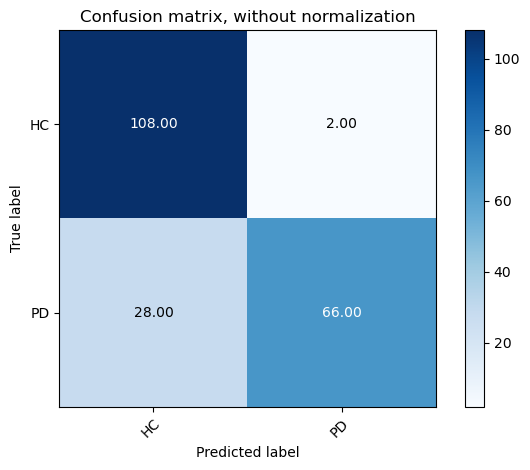

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix

plot_confusion_matrix(y_test, yhat, ["HC", "PD"])

In [ ]:
import pickle

# save the iris classification model as a pickle file
model_pkl_file = "svm_classifier_model.pkl"  

with open(model_pkl_file, 'wb') as file:  
    pickle.dump(clf, file)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import numpy as np


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(6 * num_filters + 52, 100)  # Input size is 80 (40 signs * 2)
        self.fc2 = nn.Linear(100, 20)
        self.fc3 = nn.Linear(20, 2)  # Output size is 2 for binary classification
        self.dr = nn.Dropout(p=0.5)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dr(x)
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

def train(model, train_loader, criterion, optimizer):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

def test(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    print(f'Accuracy: {100 * correct / total}%')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    
    # Create data loaders
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32).to(device), torch.tensor(y_train, dtype=torch.long).to(device))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32).to(device), torch.tensor(y_test, dtype=torch.long).to(device))
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
    
    # Initialize model, criterion, and optimizer
model = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Train the model
epochs = 20
for epoch in range(epochs):
    train(model, train_loader, criterion, optimizer)
    accuracy = test(model, test_loader)
    print(f'Epoch {epoch+1}/{epochs}')


Accuracy: 83.33333333333333%
Epoch 1/20
Accuracy: 85.29411764705883%
Epoch 2/20
Accuracy: 86.76470588235294%
Epoch 3/20
Accuracy: 85.7843137254902%
Epoch 4/20
Accuracy: 85.29411764705883%
Epoch 5/20
Accuracy: 86.27450980392157%
Epoch 6/20
Accuracy: 85.29411764705883%
Epoch 7/20
Accuracy: 86.27450980392157%
Epoch 8/20
Accuracy: 85.29411764705883%
Epoch 9/20
Accuracy: 86.27450980392157%
Epoch 10/20
Accuracy: 87.74509803921569%
Epoch 11/20
Accuracy: 86.76470588235294%
Epoch 12/20
Accuracy: 85.7843137254902%
Epoch 13/20
Accuracy: 86.76470588235294%
Epoch 14/20
Accuracy: 87.74509803921569%
Epoch 15/20
Accuracy: 86.76470588235294%
Epoch 16/20
Accuracy: 87.25490196078431%
Epoch 17/20
Accuracy: 88.23529411764706%
Epoch 18/20
Accuracy: 86.27450980392157%
Epoch 19/20
Accuracy: 87.25490196078431%
Epoch 20/20


In [ ]:
def predict(model, test_loader):
    model.eval()
    predictions = []
    true_labels = []
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(target.cpu().numpy())
    return predictions, true_labels

ypred, yreal = predict(model, test_loader)
print("Test set Accuracy: ",metrics.accuracy_score(yreal, ypred) )

Test set Accuracy:  0.8725490196078431


Confusion matrix:
 [[108   2]
 [ 28  66]]


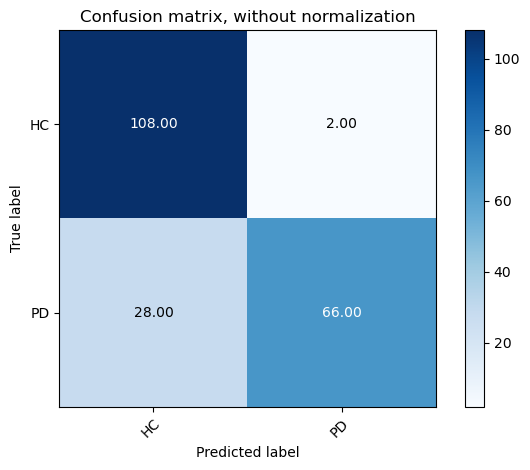

In [ ]:
plot_confusion_matrix(y_test, yhat, ["HC", "PD"])